<a href="https://colab.research.google.com/github/flohmannjr/Heart-Attack-Analysis-and-Prediction/blob/main/Heart_Attack_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Attack Analysis and Prediction

https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Setup

In [118]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEED = 2008193

# SEX_LABELS = {0: 'Female', 1: 'Male'}
# SEX_COLORS = {0: '#E52264', 1: '#2361CA'}
SEX_LABELS = ['Female', 'Male']
SEX_COLORS = ['#E52264', '#2361CA']

## Functions

In [126]:
def get_df_output(feature):

    if(type(feature) == list):
        features = feature.copy()
    else:
        features = []
        features.append(feature)

    features.append('output')

    df_output = df[features].groupby(by=feature).agg(['count', 'sum', 'mean'])

    # df_output.columns = ['_'.join(col) for col in df_output.columns.values]
    df_output.columns = df_output.columns.get_level_values(1)

    df_output.reset_index(inplace=True)

    return df_output

In [214]:
def heart_attack_by_sex(feature, label):

    df_output = get_df_output([feature, 'sex'])

    ax = sns.barplot(data=df_output, x=feature, y='mean', hue='sex', palette=SEX_COLORS)

    plt.title('')
    plt.xlabel(label)
    plt.ylabel('Chance of heart attack ratio')

    if list(df_output[feature].unique()) == [0, 1]:
        plt.xticks(ticks=[0, 1], labels=['False', 'True'])

    # sns.barplot has a bug about losing legend colors if you don't inform handles and labels together.
    handles, labels = ax.get_legend_handles_labels()

    plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white', handles=handles, labels=SEX_LABELS)

    plt.show()

# Data

In [215]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/Heart-Attack-Analysis-and-Prediction/main/heart.csv')

**Source**: Kaggle dataset (not accurate)

* **age**: Age of the patient
* **sex**: Sex of the patient
* **cp**: Chest Pain type chest pain type
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain
    * 4 = asymptomatic
* **trtbps**: resting blood pressure (in mm Hg)
* **chol**: cholesterol in mg/dl fetched via BMI sensor
* **fbs**: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
* **restecg**: resting electrocardiographic results
    * 0 = normal
    * 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalachh**: maximum heart rate achieved
* **exng**: exercise induced angina (1 = yes; 0 = no)
* **oldpeak**: 
* **slp**: 
* **caa**: number of major vessels (0-3)
* **thall**: 
* **output**: 0 = less chance of heart attack; 1= more chance of heart attack


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [217]:
df['age_group']      = (np.ceil(df['age'] / 10) * 10).astype(int)
df['trtbps_group']   = (np.ceil(df['trtbps'] / 10) * 10).astype(int)
df['chol_group']     = (np.ceil(df['chol'] / 50) * 50).astype(int)
df['thalachh_group'] = (np.ceil(df['thalachh'] / 10) * 10).astype(int)

In [218]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group,thalachh_group
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554,59.009901,133.861386,271.122112,154.422442
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835,9.117150,17.546738,55.188373,23.065838
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,100.000000,150.000000,80.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,50.000000,120.000000,250.000000,140.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,60.000000,130.000000,250.000000,160.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,70.000000,140.000000,300.000000,170.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,80.000000,200.000000,600.000000,210.000000


In [219]:
df[:5]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group,thalachh_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,70,150,250,150
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,40,130,250,190
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,50,130,250,180
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,60,120,250,180
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,60,120,400,170


# Analysis

In [220]:
get_df_output(['cp', 'sex'])

,cp,sex,count,sum,mean
0,0,0,39,18,0.461538
1,0,1,104,21,0.201923
2,1,0,18,16,0.888889
3,1,1,32,25,0.781250
4,2,0,35,34,0.971429
5,2,1,52,35,0.673077
6,3,0,4,4,1.000000
7,3,1,19,12,0.631579


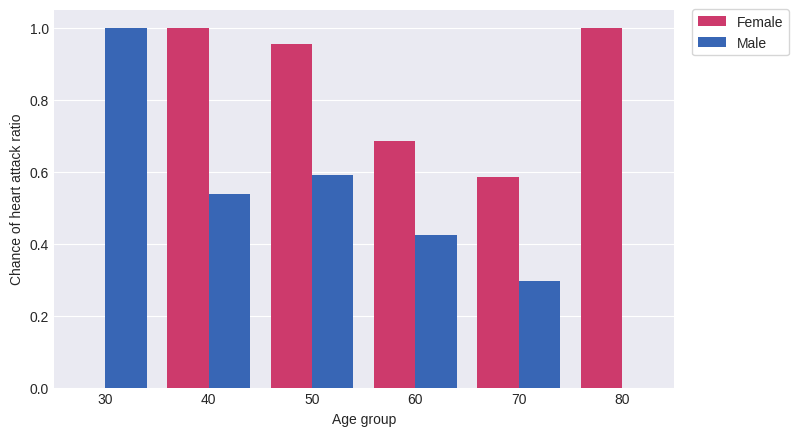

In [221]:
heart_attack_by_sex('age_group', 'Age group')

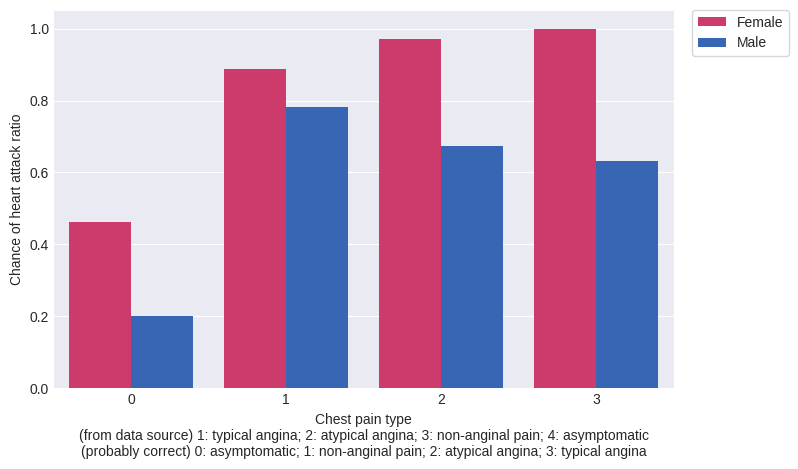

In [231]:
label  = 'Chest pain type'
label += '\n(from data source) 1: typical angina; 2: atypical angina; 3: non-anginal pain; 4: asymptomatic'
label += '\n(probably correct) 0: asymptomatic; 1: non-anginal pain; 2: atypical angina; 3: typical angina'

heart_attack_by_sex('cp', label)

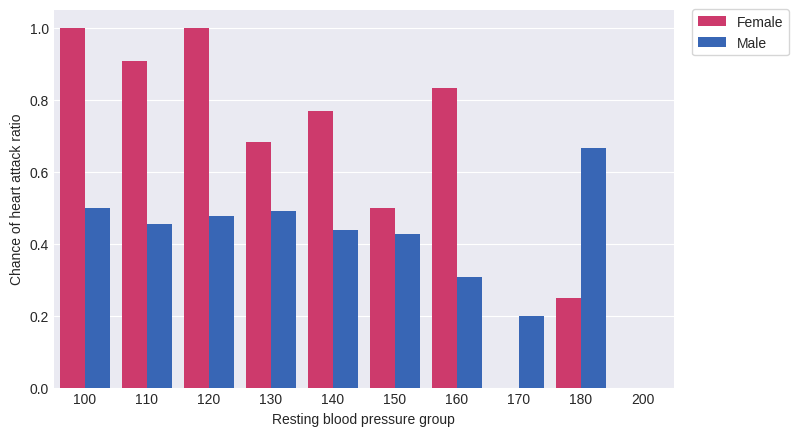

In [223]:
heart_attack_by_sex('trtbps_group', 'Resting blood pressure group')

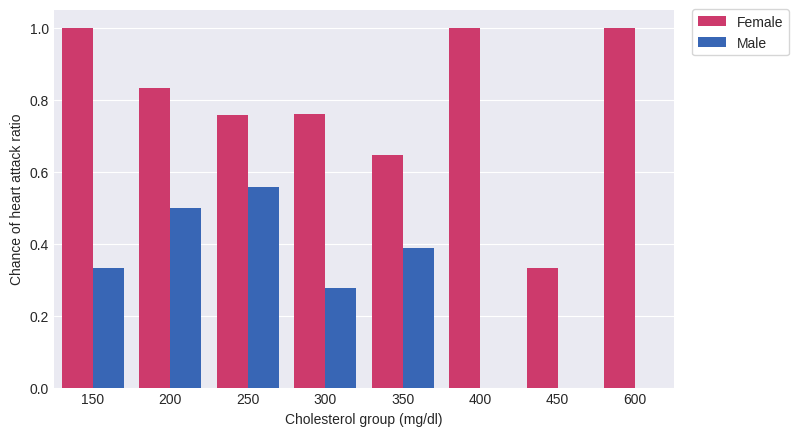

In [224]:
heart_attack_by_sex('chol_group', 'Cholesterol group (mg/dl)')

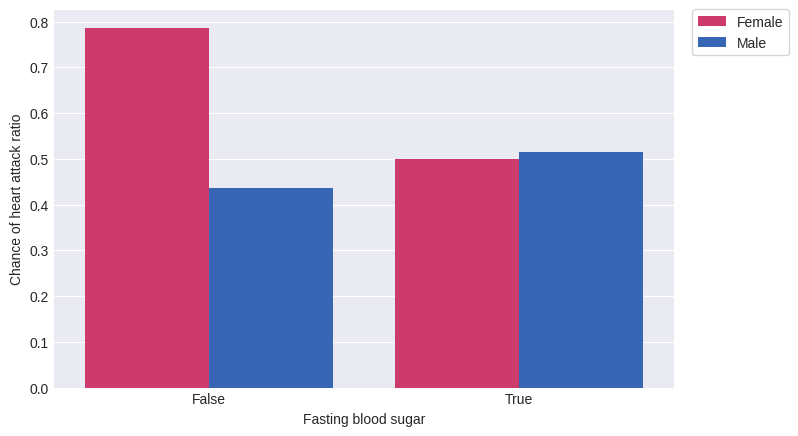

In [225]:
heart_attack_by_sex('fbs', 'Fasting blood sugar')

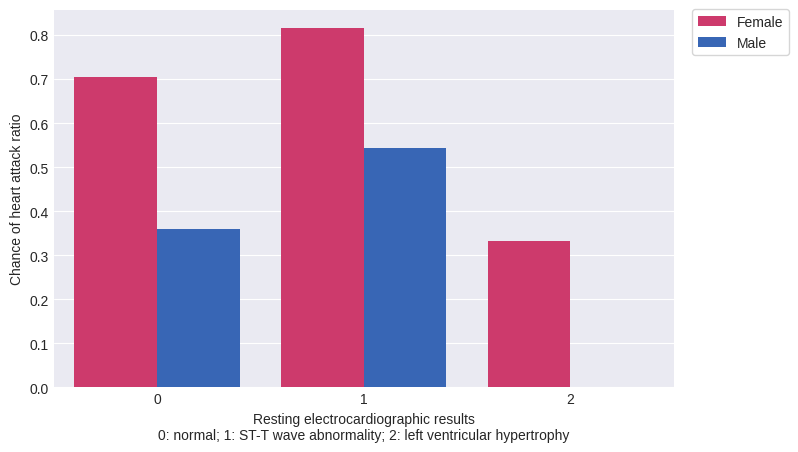

In [230]:
label  = 'Resting electrocardiographic results'
label += '\n0: normal; 1: ST-T wave abnormality; 2: left ventricular hypertrophy'

heart_attack_by_sex('restecg', label)

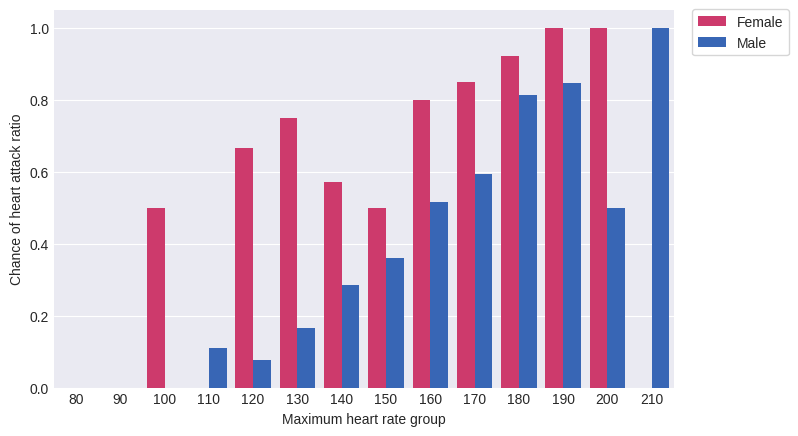

In [227]:
heart_attack_by_sex('thalachh_group', 'Maximum heart rate group')

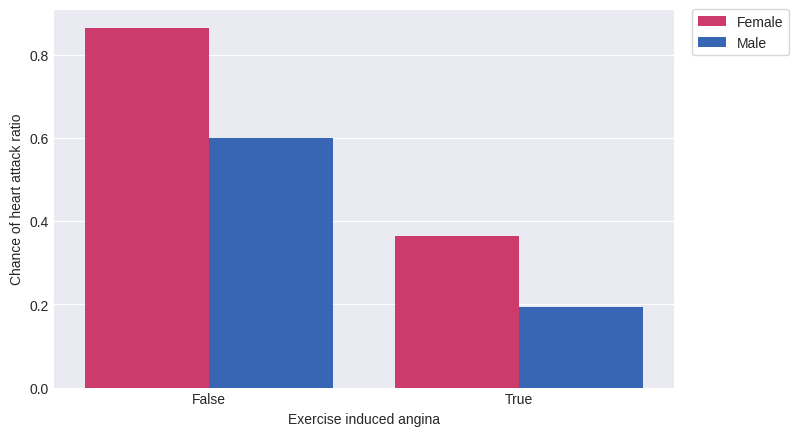

In [228]:
heart_attack_by_sex('exng', 'Exercise induced angina')

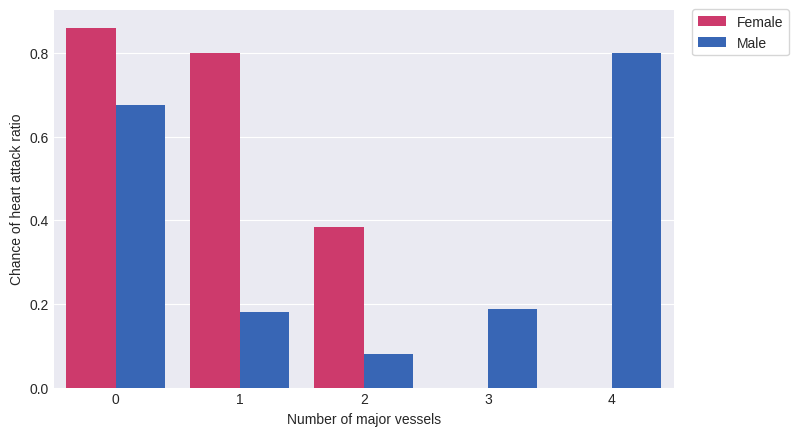

In [229]:
heart_attack_by_sex('caa', 'Number of major vessels')